## <h1>Project Proposal:</h1>

### <h2>Objective</h2>

#### <h3>Problem statement</h3>

<p>Among the many debt instruments financial institutions use, personal loans are a significant part of their retail banking portfolio. These loans contribute to revenue through higher interest rates and serve as a key tool for meeting individual consumer credit needs. Defaulting on these loans can pose a significant risk to financial institutions as they can lead to revenue loss, increased operational costs and strained relationships with borrowers. Therefore, identifying high-risk borrowers early on is critical to mitigating risk and improving the loan management process. With the help of machine learning, we aim to build a predictive model that assesses the probability of a loan defaulting in order to assist financial institutions make better data-driven decisions. 
</p>

#### <h3>Goals</h3>

<ul>
<li> Build a machine learning model to predict whether a loan will default.</li>
<li>Identify the most significant features influencing loan defaulting.</li>
<li>Provide actionable insights to enhance the risk management process for financial institutions.</li>
</ul>


### <h2>Deliverables:</h2>

#### <h3>Scope</h3>

<ul>
<li>Data preparation and cleaning. </li>
<li>Exploratory Data Analysis (EDA) to visualize trends and patterns.</li>
<li>Building and evaluating multiple machine learning models for classification.</li>
<li>Deployment of a final model as a REST API for loan risk predictions.</li>
</ul>

#### <h3>Dataset</h3>

<ul>
<li>Source: Lending Club Loan Data from Kaggle.</li>
<li>Description: Contains details on loan applicants, loan amounts, terms, interest rates, payment histories, and outcomes.</li>
</ul>

#### <h3>Deliverables</h3>
<ul> <li>A cleaned and preprocessed dataset ready for analysis.</li>
<li>Visualizations and statistical insights from EDA.</li>
<li>A predictive model with evaluation results.</li>
<li>A functional REST API for loan default predictions.</li>
<li>A final presentation summarizing the project findings.</li>
</ul>

## <h1>Data Collection and Preparation:</h1>

In [75]:
#Global Variables
SIZE_OF_SAMPLES = 1000000

import warnings
warnings.filterwarnings(action="ignore")
import pandas as pd


### Data Cleaning 

#### Rejected Data set

In [76]:
# Load the first 100,000 rows of the dataset
file_path_accepted = r"./rejected_2007_to_2018Q4.csv"
#df = pd.read_csv(file_path_accepted, nrows=SIZE_OF_SAMPLES)
df = pd.read_csv(file_path_accepted)
df.shape

(27648741, 9)

In [77]:
# Fill numerical columns with the median
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with the most frequent value (mode)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


print(f"Before Drop Columns with Too Many Missing Values (e.g., > 50%): {df.shape}")
threshold = len(df.columns) // 2
df = df.dropna(thresh=threshold)
# 3. Drop Columns with Too Many Missing Values (e.g., > 50%)
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)
columns_to_drop = missing_percentage[missing_percentage > 50].index

df = df.drop(columns=columns_to_drop)
#df = df.drop(columns=['id'])
print(f"After Drop Columns with Too Many Missing Values (e.g., > 50%): {df.shape}")

df.head()

Before Drop Columns with Too Many Missing Values (e.g., > 50%): (27648741, 9)
Amount Requested        0.0
Application Date        0.0
Loan Title              0.0
Risk_Score              0.0
Debt-To-Income Ratio    0.0
Zip Code                0.0
State                   0.0
Employment Length       0.0
Policy Code             0.0
dtype: float64
After Drop Columns with Too Many Missing Values (e.g., > 50%): (27648741, 9)


,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [78]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

#Encode the loan title
label_encoder = LabelEncoder()
df['Loan_Title_Encoded'] = label_encoder.fit_transform(df['Loan Title'])
df.head()

df['zip_code'] = df['Zip Code'].str.replace('xx', '')

df['emp_length'] = df['Employment Length'].replace({'< 1 year': '0','10+ years': '11'}).str.extract('(\d+)').astype(float)
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].str.rstrip('%').astype(float) / 100
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].apply(lambda x: x + 1 if x == 0 else x)
df['Annual_income'] =  df['Amount Requested'] / df['Debt-To-Income Ratio']
df['policy_code'] = df['Policy Code']


df['Status'] = 0
df.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0,51091,481,4.0,10000.000000,0.0,0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0,10002,010,0.0,10000.000000,0.0,0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0,50832,212,1.0,110000.000000,0.0,0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0,73332,017,0.0,15527.950311,0.0,0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0,64315,209,0.0,15906.680806,0.0,0


In [79]:
#Remove non used columns
df['Amount_Requested'] = df['Amount Requested']
df['income_debt_ratio'] = df['Debt-To-Income Ratio']
columnsToDrop = ['Amount Requested', 'Application Date', 'Loan Title', 'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length', 'Policy Code']
df = df.drop(columns=columnsToDrop)
df.head()

,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status,Amount_Requested,income_debt_ratio
0,693.0,51091,481,4.0,10000.000000,0.0,0,1000.0,0.1000
1,703.0,10002,010,0.0,10000.000000,0.0,0,1000.0,0.1000
2,715.0,50832,212,1.0,110000.000000,0.0,0,11000.0,0.1000
3,698.0,73332,017,0.0,15527.950311,0.0,0,6000.0,0.3864
4,509.0,64315,209,0.0,15906.680806,0.0,0,1500.0,0.0943


In [80]:
# 4. Save the Cleaned Dataset
output_path_rejected = f"./rejected_cleaned_{SIZE_OF_SAMPLES}_rows.csv"
df.to_csv(output_path_rejected, index=False)

print(f"Cleaned dataset saved to: {output_path_rejected}")

Cleaned dataset saved to: ./rejected_cleaned_1000000_rows.csv


#### Accepted Data Set

In [81]:
# Load the first 100,000 rows of the dataset
file_path_accepted = r"./accepted_2007_to_2018Q4.csv"
#df = pd.read_csv(file_path_accepted, nrows=SIZE_OF_SAMPLES)
df = pd.read_csv(file_path_accepted)
df.shape


(2260701, 151)

In [82]:
print(f"Before Drop Columns with Too Many Missing Values (e.g., > 50%): {df.shape}")
threshold = len(df.columns) // 2
df = df.dropna(thresh=threshold)
# 3. Drop Columns with Too Many Missing Values (e.g., > 50%)
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)
columns_to_drop = missing_percentage[missing_percentage > 10].index

df = df.drop(columns=columns_to_drop)
df = df.drop(columns=['id'])
print(f"After Drop Columns with Too Many Missing Values (e.g., > 50%): {df.shape}")
df.head()



Before Drop Columns with Too Many Missing Values (e.g., > 50%): (2260701, 151)
id                         0.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_status         98.446214
settlement_date           98.446214
settlement_amount         98.446214
settlement_percentage     98.446214
settlement_term           98.446214
Length: 151, dtype: float64
After Drop Columns with Too Many Missing Values (e.g., > 50%): (2190520, 91)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,...,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


In [ ]:
# 1. Handle Missing Values
df['zip_code'] = df['zip_code'].str.replace('xx', '')
df['term'] = df['term'].replace('< 1 year', '0').str.extract('(\d+)').astype(int)
grade_mapping = {
    'A': 4,
    'B': 3,
    'C': 2,
    'D': 1,
    'F': 0
}

# Convert grades to numerical values
df['grade'] = df['grade'].map(grade_mapping)

df['sub_grade'] = df['sub_grade'].str[1:]

df['emp_length'] = df['emp_length'].replace({'< 1 year': '0','10+ years': '11'}).str.extract('(\d+)').astype(float)


label_encoder = LabelEncoder()
df['Loan_Title_Encoded'] = label_encoder.fit_transform(df['title'])

# Fill numerical columns with the median
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with the most frequent value (mode)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


df['Status'] = 'Approved'
df.head()

In [ ]:
# 2. Remove Duplicates 
print(f"Before remove duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"After remove duplicates: {df.shape}")

Before remove duplicates: (2190520, 93)
After remove duplicates: (2190520, 93)


In [ ]:
import numpy as np
#Create the same strutucture to validate the data
df_cleaned = pd.DataFrame(columns=['Risk_Score','Loan_Title_Encoded','zip_code','emp_length','Annual_income','policy_code','Status','Amount_Requested','income_debt_ratio'])

df_cleaned['Amount_Requested'] = df['loan_amnt']
df_cleaned['emp_length'] = df['emp_length']
df_cleaned['Annual_income'] = df['annual_inc']
df_cleaned['Annual_income'].fillna(0, inplace=True)
df_cleaned['zip_code'] = df['zip_code']
df_cleaned['policy_code'] = df['policy_code']
df_cleaned['Risk_Score'] = (df['fico_range_low'] + df['fico_range_high'])/2
df_cleaned['income_debt_ratio']  = round(df_cleaned['Amount_Requested'] / df_cleaned['Annual_income'],3)
df_cleaned['income_debt_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
df_cleaned['Loan_Title_Encoded'] = df['Loan_Title_Encoded']

# Example: Preprocessing the target variable
def preprocess_target_status(status):
    return 0 if status in ['Charged Off', 'Defaulted'] else 1

# Create the binary target variable
df_cleaned['Status'] = df['loan_status'].apply(preprocess_target_status)
df_cleaned = df_cleaned[df_cleaned['Status'] != 0]

df_cleaned.head()

#df.columns.to_list()


,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status,Amount_Requested,income_debt_ratio
0,677.0,10685,190,11.0,55000.0,1.0,1,3600.0,0.065
1,717.0,2861,577,11.0,65000.0,1.0,1,24700.0,0.380
2,697.0,39127,605,11.0,63000.0,1.0,1,20000.0,0.317
3,787.0,10685,076,11.0,110000.0,1.0,1,35000.0,0.318
4,697.0,19188,174,3.0,104433.0,1.0,1,10400.0,0.100


In [ ]:
# 4. Save the Cleaned Dataset
output_path_accepted = f"./accepted_cleaned_{SIZE_OF_SAMPLES}_rows.csv"
df_cleaned.to_csv(output_path_accepted, index=False)

print(f"Cleaned dataset saved to: {output_path_accepted}")


Cleaned dataset saved to: ./accepted_cleaned_100000_rows.csv


### Exploratory Data Analysis 

#### Setup and Variable Initializations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure visualizations
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)



In [ ]:
# Load only the first 50,000 rows of each dataset
accepted_data = pd.read_csv(output_path_accepted, nrows=SIZE_OF_SAMPLES)
rejected_data = pd.read_csv(output_path_rejected, nrows=SIZE_OF_SAMPLES)

# Combine the two datasets
df = pd.concat([accepted_data, rejected_data], ignore_index=True)

# Inspect the first few rows to verify the data
df.head(1)



,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status,Amount_Requested,income_debt_ratio
0,677.0,10685,190,11.0,55000.0,1.0,1,3600.0,0.065


#### Data Analysis

In [ ]:

# 1. Dataset Overview
print(f"Dataset Shape: {df.shape}")

print("Dataset Info:")
print(df.info())

print("Sample Rows:")
df.head()



Dataset Shape: (200, 9)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk_Score          200 non-null    float64
 1   Loan_Title_Encoded  200 non-null    int64  
 2   zip_code            200 non-null    int64  
 3   emp_length          200 non-null    float64
 4   Annual_income       200 non-null    float64
 5   policy_code         200 non-null    float64
 6   Status              200 non-null    int64  
 7   Amount_Requested    200 non-null    float64
 8   income_debt_ratio   200 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 14.2 KB
None
Sample Rows:


,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status,Amount_Requested,income_debt_ratio
0,677.0,10685,190,11.0,55000.0,1.0,1,3600.0,0.065
1,717.0,2861,577,11.0,65000.0,1.0,1,24700.0,0.380
2,697.0,39127,605,11.0,63000.0,1.0,1,20000.0,0.317
3,787.0,10685,76,11.0,110000.0,1.0,1,35000.0,0.318
4,697.0,19188,174,3.0,104433.0,1.0,1,10400.0,0.100


In [ ]:
# 2. Missing Values Analysis
missing = df.isnull().sum()
missing_percentage = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

print("\nColumns with Missing Values:")
print(missing_df)

# Visualize missing values
if missing_df.shape[0] > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()


Columns with Missing Values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [ ]:
# 3. Descriptive Statistics
print("\nStatistical Summary (Numerical Columns):")
df.describe().T


Statistical Summary (Numerical Columns):


,count,mean,std,min,25%,50%,75%,max
Risk_Score,200.0,627.385000,154.958729,0.0000,580.50000,682.000000,702.25000,837.000000
Loan_Title_Encoded,200.0,30665.035000,24137.961649,951.0000,10685.00000,18014.500000,53809.50000,73910.000000
zip_code,200.0,432.875000,261.198300,10.0000,219.75000,430.500000,647.50000,993.000000
emp_length,200.0,3.920000,4.152084,0.0000,0.00000,2.000000,6.00000,11.000000
Annual_income,200.0,72229.398812,97398.879702,1000.0000,23952.76263,50038.520801,90348.00000,967741.935484
policy_code,200.0,0.500000,0.501255,0.0000,0.00000,0.500000,1.00000,1.000000
Status,200.0,0.500000,0.501255,0.0000,0.00000,0.500000,1.00000,1.000000
Amount_Requested,200.0,10606.250000,8345.875727,1000.0000,3825.00000,9000.000000,15887.50000,35000.000000
income_debt_ratio,200.0,0.250007,0.235777,0.0072,0.10000,0.177650,0.31805,1.000000


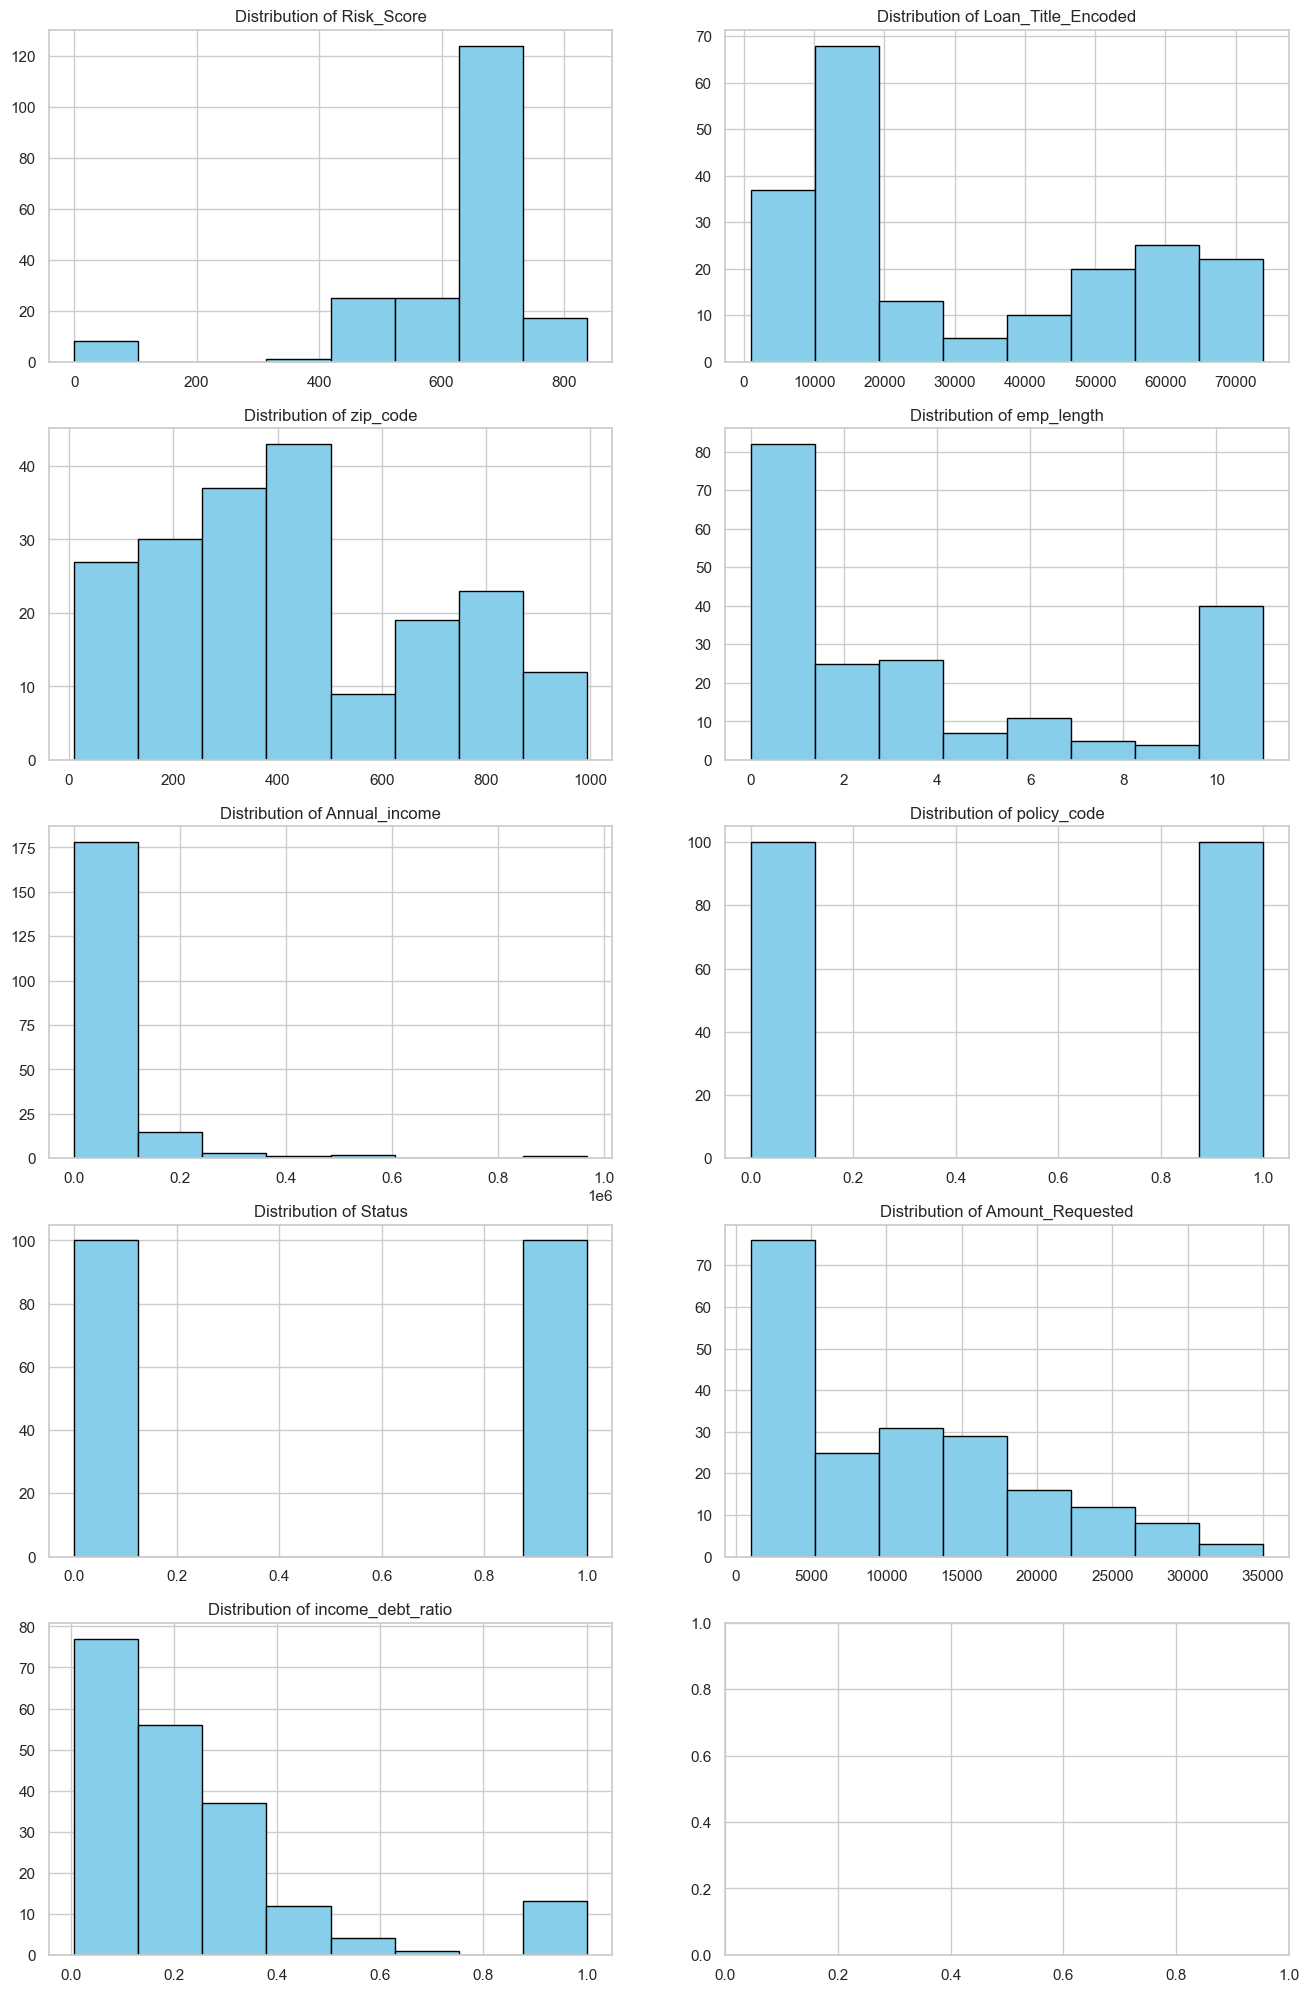

<Figure size 1000x600 with 0 Axes>

Categorical Columns


In [ ]:
import math

# 4. Univariate Analysis
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Filter numerical columns to exclude empty or constant columns
valid_numerical_cols = [col for col in numerical_cols if df[col].nunique() > 1 and not df[col].isnull().all()]

# Numerical data distributions
num_columns = 2
num_features =len(valid_numerical_cols)
num_rows = math.ceil(num_features/num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 5 * num_rows))
axes = axes.flatten()  # Flatten axes to iterate easily

for i, col in enumerate(valid_numerical_cols):
    if df[col].dropna().nunique() > 1:  # Ensure column has sufficient variation
        df[col].hist(ax=axes[i], bins=8, edgecolor="black", color='skyblue')
        axes[i].set_title(f"Distribution of {col}")
plt.show()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print('Categorical Columns')
# Categorical data distributions (Top 5)
for col in categorical_cols[:5]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10], palette='muted')
    plt.title(f"Distribution of Top Categories for {col}")
    plt.show()


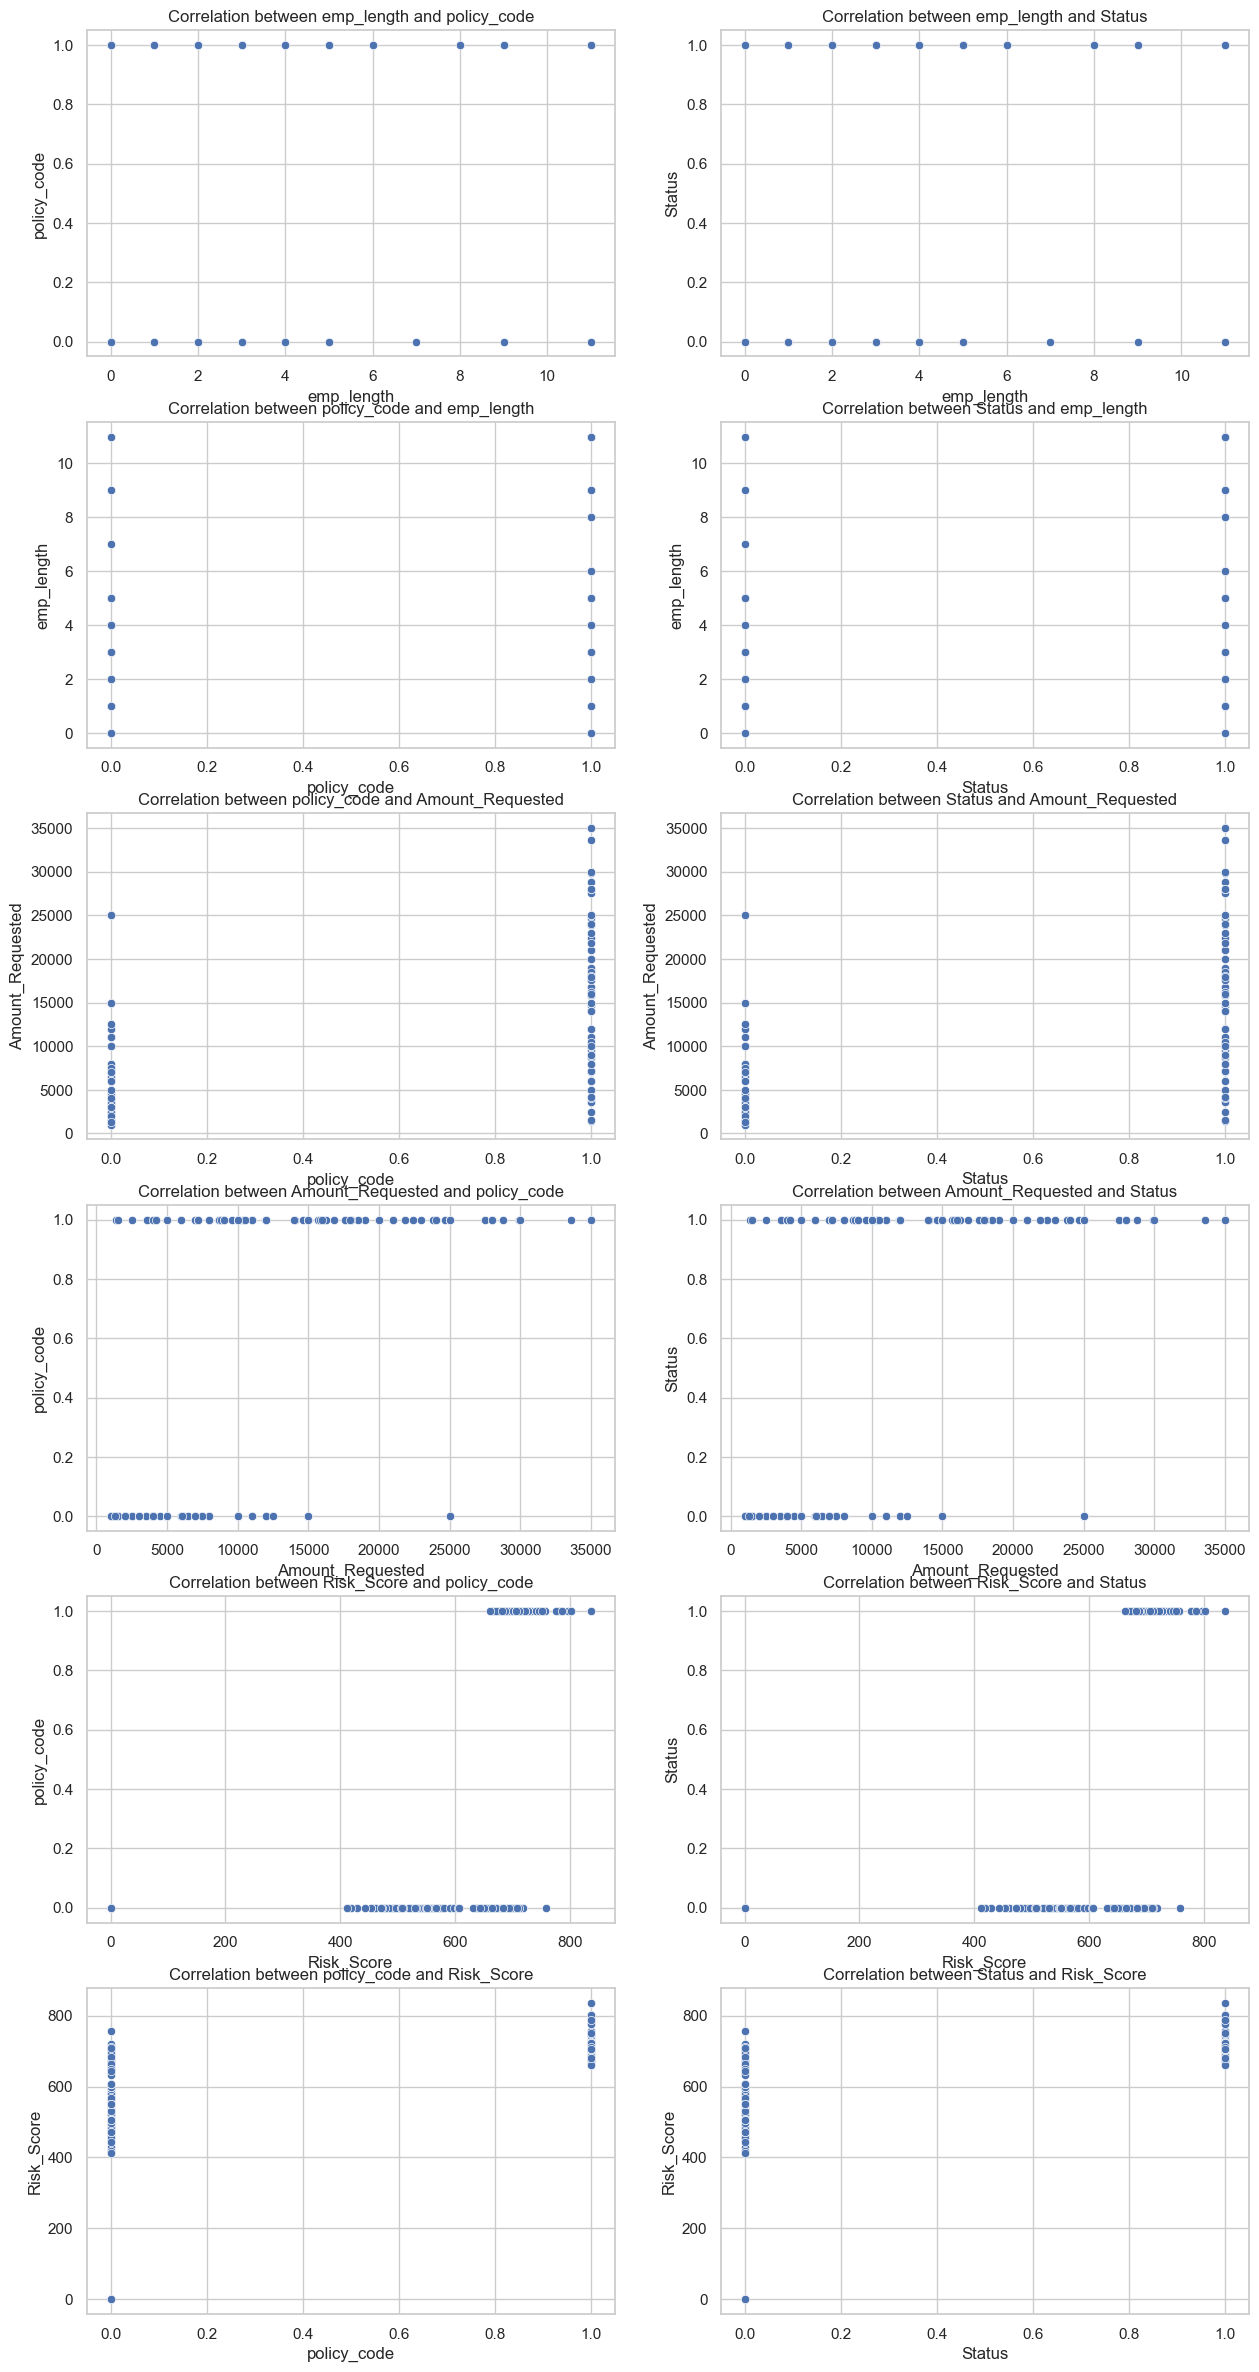

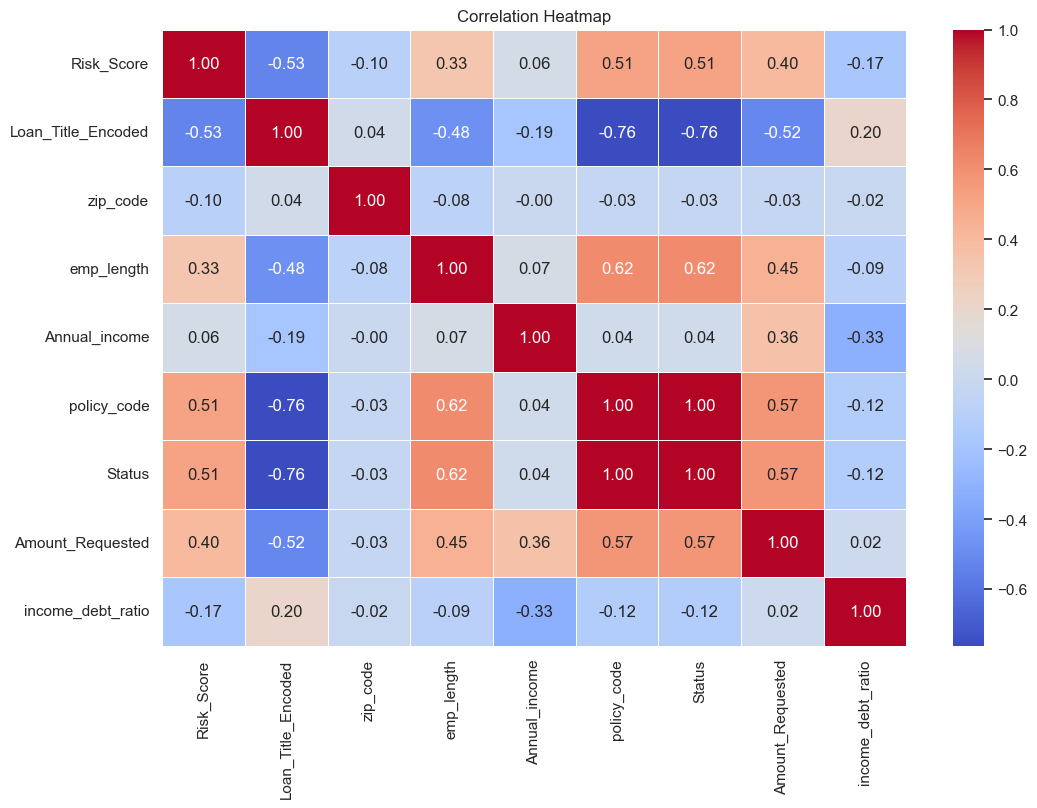

In [ ]:
# 5. Bivariate Analysis
# Correlation Heatmap
corr = df[valid_numerical_cols].corr()

# Filter meaningful correlations
strong_corr = corr[(corr > 0.5) & (corr < 1)].stack().reset_index()
strong_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#print("\nStrong Correlations:")
#print(strong_corr.sort_values(by='Correlation', ascending=False)[:10])

# Numerical data distributions
num_columns = 2
num_features =20
num_rows = math.ceil(num_features/num_columns)

plt.figure(figsize=(15, 5*num_rows))

# Plot scatter plots for each pair of features
i = 1
for _, row in strong_corr.sort_values(by='Correlation', ascending=False)[:20].iterrows():
    
    feature1, feature2 = row['Feature 1'], row['Feature 2']
    if feature1 in df.columns and feature2 in df.columns:
        plt.subplot(num_rows, num_columns, i)
        sns.scatterplot(x=df[feature1], y=df[feature2])
        plt.title(f"Correlation between {feature1} and {feature2}")
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        
    else:
        print(f"One or both features ({feature1}, {feature2}) not found in the dataset.")
    i = i + 1
plt.show()
# Plotting correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

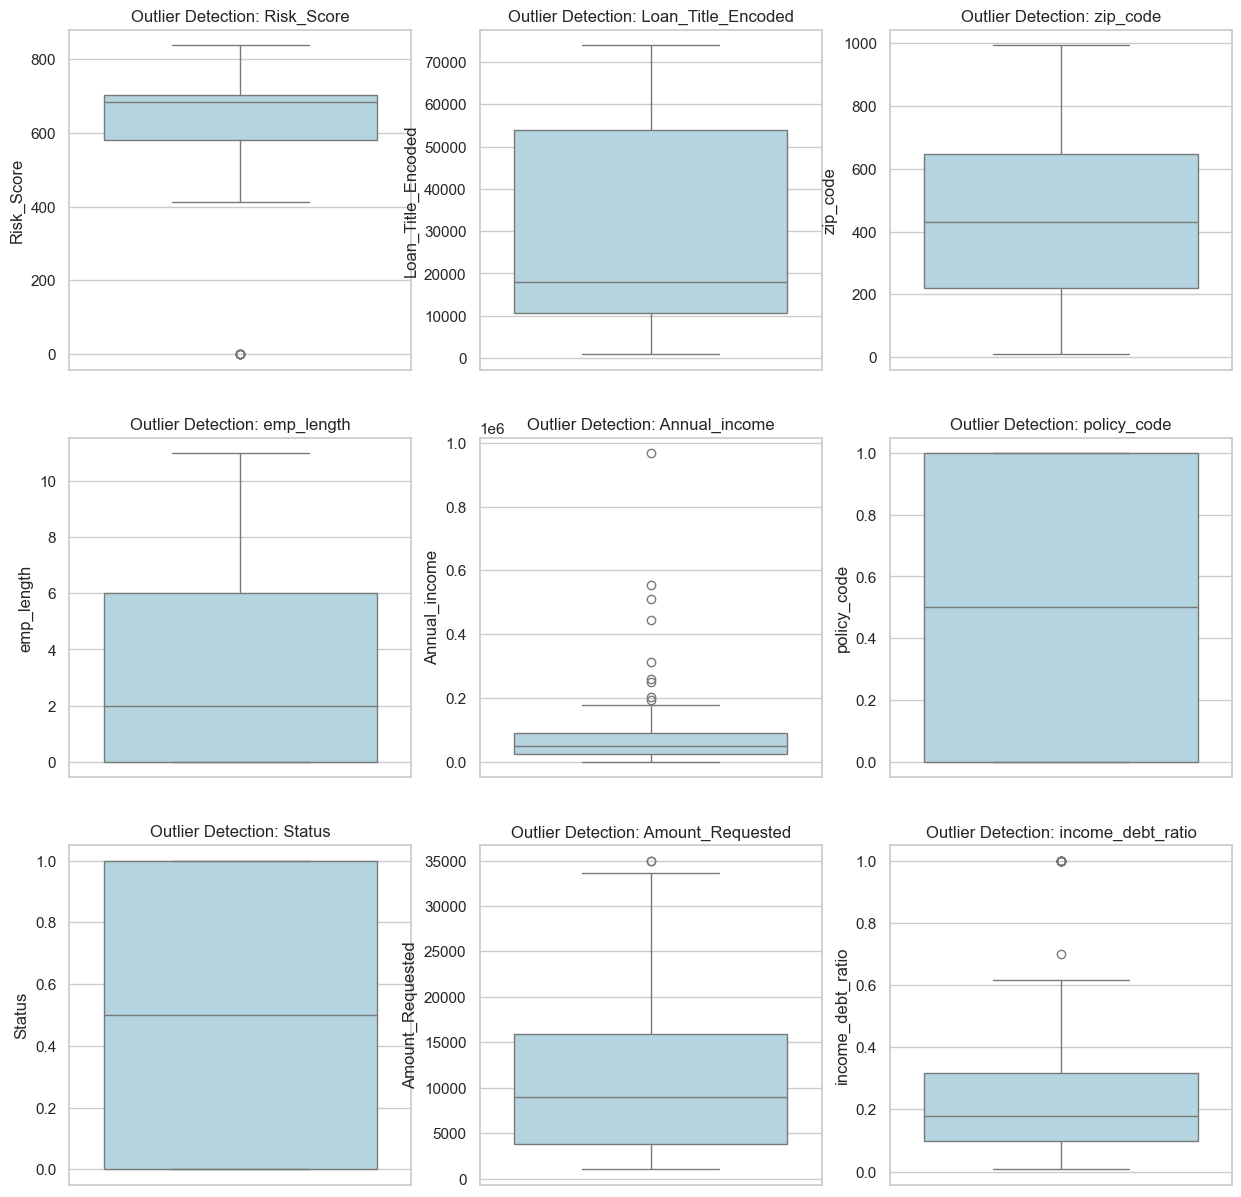

In [ ]:
# 6. Outlier Detection
import math

num_columns = 3
num_features =len(valid_numerical_cols)
num_rows = math.ceil(num_features/num_columns)

# Boxplots for Outliers (Only for Valid Numerical Columns)

plt.figure(figsize=(15, 5*num_rows))
for i, col in enumerate(valid_numerical_cols, start=1):
    if df[col].dropna().nunique() > 1:  # Ensure column has sufficient variation
        plt.subplot(num_rows, num_columns, i)
        sns.boxplot(y=col, data=df, color='lightblue')
        plt.title(f"Outlier Detection: {col}")
plt.show()

In [ ]:
# 7. Data Cleaning Example (Missing Values)
df_cleaned = df.copy()

# Fill missing values (example: median imputation for numerical columns)
for col in valid_numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()
print(f"\nDataset Shape After Cleaning: {df_cleaned.shape}")


Dataset Shape After Cleaning: (200, 9)


In [ ]:
# 8. Feature Engineering Example
# Final Dataset Preview
print("\nFinal Cleaned Dataset Preview:")
df_cleaned.head()



Final Cleaned Dataset Preview:


,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Status,Amount_Requested,income_debt_ratio
0,677.0,10685,190,11.0,55000.0,1.0,1,3600.0,0.065
1,717.0,2861,577,11.0,65000.0,1.0,1,24700.0,0.380
2,697.0,39127,605,11.0,63000.0,1.0,1,20000.0,0.317
3,787.0,10685,76,11.0,110000.0,1.0,1,35000.0,0.318
4,697.0,19188,174,3.0,104433.0,1.0,1,10400.0,0.100


In [ ]:
print("\nEDA Complete!")



EDA Complete!


## Model Selection and Building

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Drop columns irrelevant to the prediction
X = df_cleaned.drop(columns=['Status'])  # Drop target and ID
y = df_cleaned['Status']  # Set target column


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (160, 8)
Test set size: (40, 8)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
X_train.describe()

,Risk_Score,Loan_Title_Encoded,zip_code,emp_length,Annual_income,policy_code,Amount_Requested,income_debt_ratio
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,625.506250,31596.275000,439.975000,3.875000,67021.287729,0.493750,10744.687500,0.257673
std,158.938064,24731.964412,260.339231,4.080557,72931.541538,0.501531,8608.645002,0.239671
min,0.000000,951.000000,10.000000,0.000000,1000.000000,0.000000,1000.000000,0.007200
25%,588.750000,10685.000000,232.000000,0.000000,21193.877551,0.000000,3375.000000,0.100000
50%,682.000000,18676.000000,431.500000,2.000000,51000.000000,0.000000,10000.000000,0.184650
75%,702.250000,57051.500000,658.500000,6.000000,88848.000000,1.000000,16000.000000,0.326550
max,837.000000,73910.000000,993.000000,11.000000,555555.555556,1.000000,35000.000000,1.000000


#### Logistic Regression 

In [ ]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_results = {
    "Fold": [f"Fold {i+1}" for i in range(len(cv_scores))],
    "Accuracy": cv_scores
}

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.loc["Mean"] = ["Mean", cv_scores.mean()]
cv_results_df.loc["Std"] = ["Std Dev", cv_scores.std()]
cv_results_df.head()



Logistic Regression Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix:
[[19  0]
 [ 0 21]]


,Fold,Accuracy
0,Fold 1,0.93750
1,Fold 2,1.00000
2,Fold 3,0.96875
3,Fold 4,1.00000
4,Fold 5,0.96875


In [ ]:
cv_results_df.head()

,Fold,Accuracy
0,Fold 1,0.93750
1,Fold 2,1.00000
2,Fold 3,0.96875
3,Fold 4,1.00000
4,Fold 5,0.96875


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))



Random Forest Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix:
[[19  0]
 [ 0 21]]


#### Gradient Boosting (XGBoost)

In [ ]:
from xgboost import XGBClassifier

# Train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix:
[[19  0]
 [ 0 21]]


### Decision Tree

Decision Tree Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Confusion Matrix:
[[19  0]
 [ 0 21]]


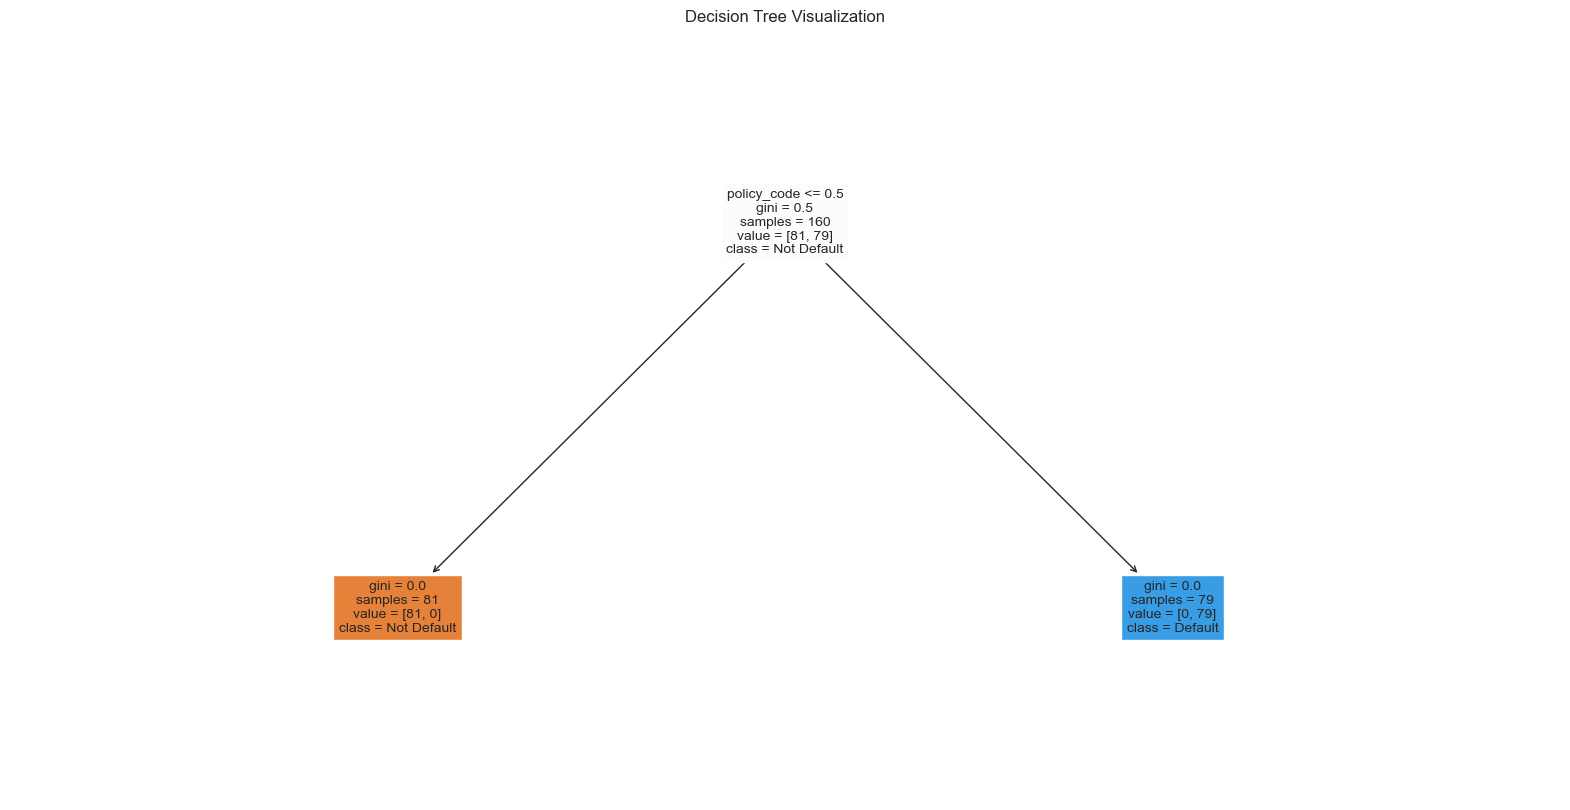

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train the Decision Tree Model
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the Model
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=["Not Default", "Default"], filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


# Model Evaluations

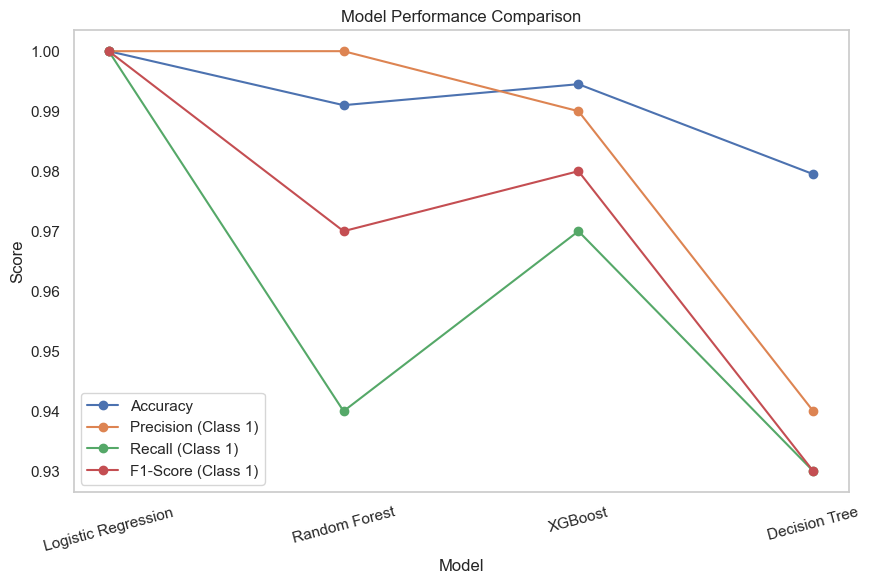

In [ ]:
# Compile Metrics
data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "Decision Tree"],
    "Accuracy": [1.000, 0.9910, 0.9945, 0.9795],
    "Precision (Class 1)": [1.00, 1.00, 0.99, 0.94],
    "Recall (Class 1)": [1.00, 0.94, 0.97, 0.93],
    "F1-Score (Class 1)": [1.00, 0.97, 0.98, 0.93],
}

# Convert to DataFrame
comparison_df = pd.DataFrame(data)

# Visualize the Metrics
plt.figure(figsize=(10, 6))
for metric in ["Accuracy", "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)"]:
    plt.plot(comparison_df["Model"], comparison_df[metric], marker="o", label=metric)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.xticks(rotation=15)
plt.show()


We used four models to make predictions about loan defaults: Logistic Regression, Random Forest, XGBoost, and Decision Tree. These models were evaluated based on their accuracy, precision, recall, F1-score, and confusion matrices.

Logistic Regression achieved perfect classification scores. While this might seem like the best model, the perfect scores actually indicate overfitting. This model is unlikely to generalize well to unseen data and struggles to capture the non-linear relationships within the dataset.

Random Forest performed quite well, achieving an accuracy of 99.1%, precision of 1.0, and recall of 0.94. This model is better equipped to identify non-linear relationships, is robust to imbalanced data, and provides highly interpretable feature importances.

XGBoost outperformed Random Forest with an accuracy of 99.45% and a higher recall score of 0.97, demonstrating superior ability to reduce false negatives. This model is extremely scalable and excels at capturing complex patterns, making it the most suitable model for this task.

Decision Tree had the lowest accuracy at 97.95% and the lowest recall at 0.93, suggesting it is more prone to overfitting. While simple and interpretable, the model’s simplicity comes at the cost of robustness and generalization.

In conclusion, XGBoost is the best model due to its superior recall and adaptability, followed by Random Forest for its balance of simplicity and performance. Decision Tree in the last option because its robust for the dataset. Logistic Regression can serve as a baseline but should not be used for predictions as it tends to overfit to the data. 

###  Hyperparameter Tuning using  RandomizedSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Results
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Evaluate on the test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)

print(f"Test set accuracy with the best model: {test_score:.4f}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_spl

In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Results
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Evaluate on the test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)

print(f"Test set accuracy with the best model: {test_score:.4f}")
best_model.save('FinalModel.pkl')


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.0

AttributeError: 'XGBClassifier' object has no attribute 'save'

We have used `RandomizedSearchCV` for hyperparameter tuning because it allows us to efficiently explore the hyperparameter space of complex models like RandomForestClassifier and XGBClassifier. By randomly sampling a subset of possible configurations, it reduces the computational cost and risk of overfitting, while still identifying promising hyperparameter combinations. This approach enables us to achieve better model performance with fewer computational resources, making it ideal for optimizing the models in practical applications.